In [1]:
import requests # Загрузка новостей с сайта.
from bs4 import BeautifulSoup # Превращалка html в текст.
import re # Регулярные выражения.
import pandas as pd
from datetime import date
from datetime import timedelta
import nltk
import nltk.data
from tqdm.notebook import tqdm
from gensim.models.word2vec import Word2Vec
import pymorphy2
%matplotlib inline
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors # Семантические вектора.
import numpy as np
from umap import UMAP
# from numba import jit
from sklearn.manifold import TSNE
from matplotlib.pyplot import figure
from sklearn.cluster import DBSCAN
import seaborn as sns
from matplotlib.colors import ListedColormap
from numpy.random import choice
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from numpy.random import choice
from scipy.cluster.hierarchy import linkage, dendrogram

# Выгрузка новостей

In [51]:
# Получение ссылок новостей за день
def get_news_for_day(day):
    links = []
    
    url_root = 'http://tramuk.ru'
    url = url_root + '/date/' + str(day.year) + '/' + str(day.month) + '/' + str(day.day) + '.html'
    # Теперь выделим только то, что взято в тег h2.
    h2s=BeautifulSoup(requests.get(url).text, "html5lib").find_all("h2")
    # Формируем список ссылок. Для этого берем первую (кстати, единственную) ссылку из каждого выделенного
    # фрагмента, у нее берем значение параметра href. Так как ссылки внутренние, добавляем к ним адрес сайта.
    links=["http://tramuk.ru"+l.find_all("a")[0]["href"] for l in h2s]
    return links

In [52]:
# Получение новостей по ссылке
def get_news_text(url):
    page_text = requests.get(url).text
    bs=BeautifulSoup(page_text, "html5lib")
    title = None
    # Заголовок
    title = bs.h1.text
    # Сам текст
    whole_text = bs.find_all('div', 'itemBody')
    text = None
    for i in range(len(whole_text)):
        text = " ".join([p.text for p in whole_text[i].find_all("p")])
        if not text:
            text = " ".join(whole_text[i].text.split('\n\n'))
    class_news = bs.find_all('div', 'itemCategory')
    # Класс статьи
    class_text = None
    for i in range(len(class_news)):
        class_text = " ".join([p.text for p in class_news[i].find_all("a")])
        if not class_text:
            class_text = " ".join(class_news[i].text.split('\n\n'))
    return {'title': title,
            'text': text,
           'class':class_text}

In [53]:
# Запись в уже октрытый файл
def save_text_to_file(file, data, date):
    title = str(data['title']).encode().decode('utf-8')
    text = str(data['text']).encode().decode('utf-8')
    cls = str(data['class']).encode().decode('utf-8')
    text = text.strip('\n')
    text = text.strip()
    file.write('\n=====\n'+title)
    file.write('\n+++++\n')
    file.write(str(date.year) + '/' + str(date.month) + '/' + str(date.day))
    file.write('\n-----\n' + text)
    file.write('\n#####\n' + cls)

In [56]:
filename = 'Data/text3.txt'
file=open(filename, 'w', encoding='utf-8')
file.close()

In [57]:
%%time
# filename = 'Data/text3.txt'
# file=open(filename, 'w', encoding='utf-8')
# file.close()
begin_date = date(2015, 1, 1)
itr = begin_date
delta = timedelta(days=1)
# end_date = date.today() + delta
end_date = date.today()
sum_days = end_date - begin_date
file=open(filename, 'a', encoding='utf-8')
while itr != end_date:
    likns = []
    link_list = get_news_for_day(itr)
    for i in range(len(link_list)):
        try:
            data = get_news_text(link_list[i])
            save_text_to_file(file, data, itr)
        except Exception as err:
            print(err)
            print('Date: ' + str(itr))
            print('step: ' + str((itr - begin_date).days))
    print(str((itr - begin_date).days)+"/"+str((sum_days-delta).days), end='\r')
    
    itr += delta
    
file.close()
print(str((itr - begin_date).days)+"/"+str((sum_days-delta).days), end='\r')
print('Success!!!\n')

Success!!!

Wall time: 1h 25min 12s


# Векторизация текстов по готовой модели

In [2]:
model_w2v = KeyedVectors.load_word2vec_format('Data/araneum_upos_skipgram_300_2_2018.vec.gz')

In [3]:
# Список значимых частей речи.
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 'VERB':'VERB'}

tmp_dict = {}
nones = {}

morph = pymorphy2.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy3(text):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        elif t in nones.keys():
            pass
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    words.append(pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS])
                    tmp_dict[t] = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                else:
                    nones[t] = ""
                    
    return words

In [4]:
print(model_w2v.vector_size)
print(len(model_w2v.index2word))

300
196620


In [5]:
index2word_set = set(model_w2v.index2word)

def text_to_vec(text):
    text_vec = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy3(text):
        if word in index2word_set:
            n_words = n_words + 1
            text_vec = np.add(text_vec, model_w2v[word]) 
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec

In [6]:
with open("Data/text3.txt", encoding="utf-8") as newsfile: # Файл с новостями.
    text = newsfile.read()
    div_text = text.split("\n=====\n")[1:]
    text_news = [(n.split("\n+++++\n")[0],
                  n.split("\n+++++\n")[1].split("\n-----\n")[0],
                  n.split("\n-----\n")[1].split("\n#####\n")[0],
                  n.split("\n#####\n")[1]) 
                 for n in div_text]
    news = pd.DataFrame(text_news, columns = ['Header', 'Date', 'News', 'Class'])

In [7]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5887 entries, 0 to 5886
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Header  5887 non-null   object
 1   Date    5887 non-null   object
 2   News    5887 non-null   object
 3   Class   5887 non-null   object
dtypes: object(4)
memory usage: 92.0+ KB


In [8]:
news.tail()

,Header,Date,News,Class
5882,\n\t\t\t\t\t \n\t\t\t\tУ России два союзника…...,2020/11/12,Почему наша страна в плотном кольце недругов? ...,Общество
5883,\n\t\t\t\t\t \n\t\t\t\tПри содействии ЦЗН Уст...,2020/11/13,Мамы Челябинской области бесплатно осваивают н...,Общество
5884,\n\t\t\t\t\t \n\t\t\t\t12 новых случаев забол...,2020/11/13,"По данным на утро 13 ноября, в Усть-Катаве с н...",Новости
5885,\n\t\t\t\t\t \n\t\t\t\tГубернатор Челябинской...,2020/11/13,"Сегодня, 13 ноября, состоялась международная к...",Совершенно официально
5886,\n\t\t\t\t\t \n\t\t\t\tМошенник «увёл» с карт...,2020/11/13,Ежедневно полиция информирует население о случ...,Общество


In [9]:
news.head()

,Header,Date,News,Class
0,\n\t\t\t\t\t \n\t\t\t\tМолодежь приглашают ра...,2015/1/12,"Радио ENERGY, Вести.Ru, Men’sHealth, газета «М...",Новости
1,\n\t\t\t\t\t \n\t\t\t\tНовогодним подарком ст...,2015/1/12,В конце минувшего года преподаватель Усть-Ката...,Общество
2,\n\t\t\t\t\t \n\t\t\t\tВ Челябинске прошёл че...,2015/1/13,10-11 января в Челябинске в ледовом дворце «Ур...,Спорт
3,\n\t\t\t\t\t \n\t\t\t\tВ Челябинской области ...,2015/1/13,Прошлогодний опрос выявил семь несостоятельных...,Общество
4,\n\t\t\t\t\t \n\t\t\t\tШахматисты Усть-Катава...,2015/1/13,Любители шахмат не изменяют своим традициям: и...,Спорт


In [10]:
news.News[1]

'В конце минувшего года преподаватель Усть-Катавского\xa0техникума получила почётную грамоту ЗСО. По информации помощника депутата ЗСО Аллы Кривошеевой, 30 декабря в актовом зале индустриально-технологического техникума депутат Законодательного собрания области Марат Новичков вручил преподавателю специальных дисциплин Татьяне Федосовой почётную грамоту Заксобрания за значительный вклад в образовательную систему Усть-Катавского городского округа и многолетний добросовестный труд, а также денежную премию в размере 10 тысяч рублей. Во время поздравления Марат Леонидович отметил, что в уходящем году отмечалось 85-летие профессионального образования в городе Усть-Катаве, и Заксобрание области не могло обойти вниманием такое знаменательное событие. В заключение своего выступления депутат пожелал всем присутствующим здоровья, добра, мира и благоденствия.'

In [11]:
news.Class[1]

'Общество'

## Замена категорий на числа

In [12]:
news2 = news[['Header', 'Date', 'News', 'Class']].copy()

In [13]:
news2['Class'] = news2['Class'].replace({'Новости':0,
                                         'Общество':1,
                                         'Культура':2,
                                         'Спорт':3,
                                         'Образование':4,
                                         'На досуге':5,
                                        'Интервью':6,
                                        'Совершенно официально':7,
                                        'Сельское хозяйство':8})

In [14]:
news2.tail()

,Header,Date,News,Class
5882,\n\t\t\t\t\t \n\t\t\t\tУ России два союзника…...,2020/11/12,Почему наша страна в плотном кольце недругов? ...,1
5883,\n\t\t\t\t\t \n\t\t\t\tПри содействии ЦЗН Уст...,2020/11/13,Мамы Челябинской области бесплатно осваивают н...,1
5884,\n\t\t\t\t\t \n\t\t\t\t12 новых случаев забол...,2020/11/13,"По данным на утро 13 ноября, в Усть-Катаве с н...",0
5885,\n\t\t\t\t\t \n\t\t\t\tГубернатор Челябинской...,2020/11/13,"Сегодня, 13 ноября, состоялась международная к...",7
5886,\n\t\t\t\t\t \n\t\t\t\tМошенник «увёл» с карт...,2020/11/13,Ежедневно полиция информирует население о случ...,1


In [23]:
w2v_vectors = [text_to_vec(text) for text in news2.News]

# Кластеризация векторов новостей

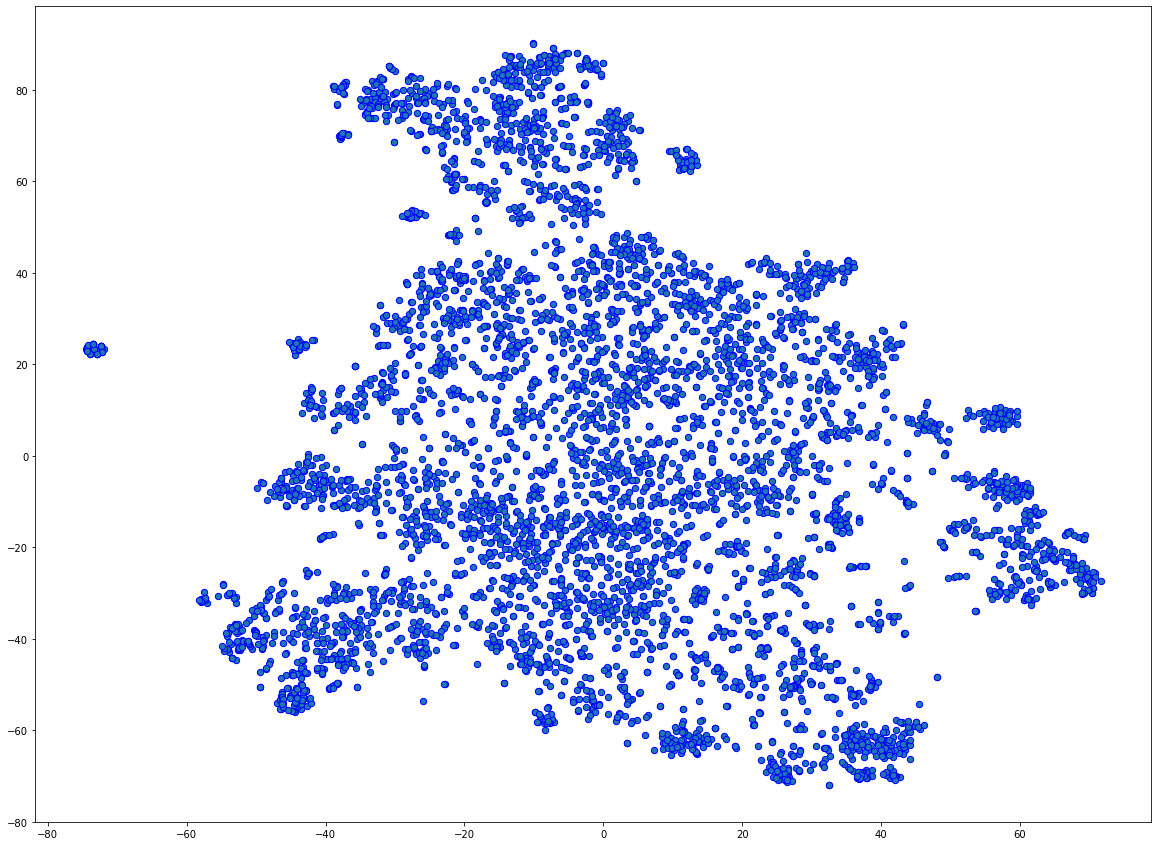

In [24]:
tsne=TSNE()
tsne_vct = tsne.fit_transform(w2v_vectors)

fig, ax = plt.subplots(figsize=(20, 15))
ax.scatter(tsne_vct[:, 0], tsne_vct[:, 1], 
           cmap=plt.cm.autumn, edgecolor='b', s=40)
plt.show()

## Кластеризация DBSCAN

Оцениим расстояние эпсилон

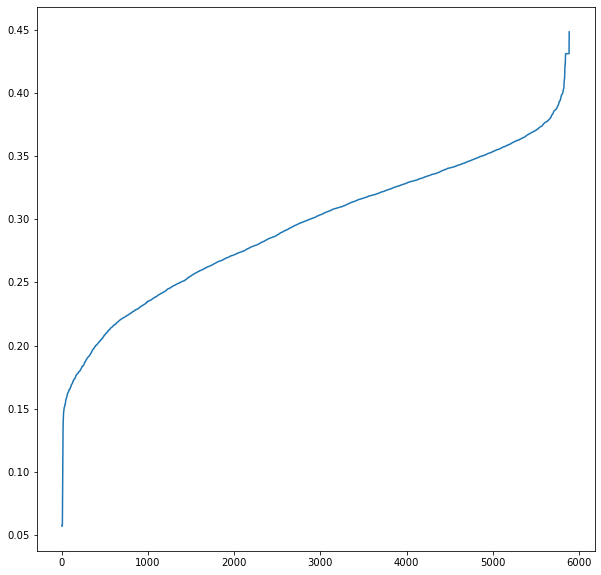

In [18]:
wm = kneighbors_graph(w2v_vectors, 3, n_jobs=-1)
nzr, nzc = wm.nonzero()
neighbours = np.zeros(len(w2v_vectors))
vpos=7
v1 = text_to_vec(news2.News[vpos])
for r, c in zip(nzr, nzc):
    neighbours[r] += np.linalg.norm(v1-w2v_vectors[c])
    
neighbours=sorted(neighbours/3)
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(range(len(neighbours)), neighbours)
plt.show()

Возьмём эпсилон 0.2

155


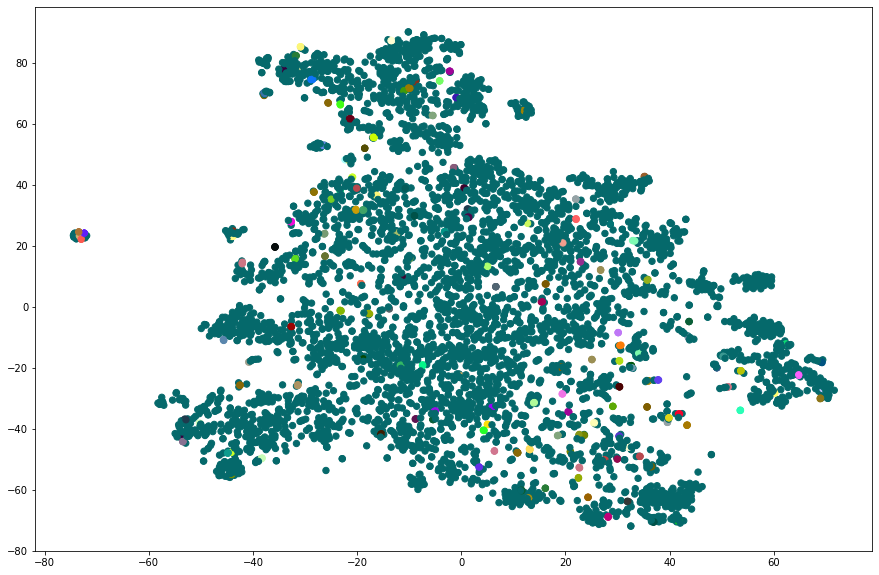

Wall time: 540 ms


In [41]:
%%time
db=DBSCAN(eps=0.2, min_samples=3)
db_clusters=db.fit_predict(tsne_vct)
myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
print(max(db_clusters))
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(tsne_vct[:, 0], tsne_vct[:, 1], s=40, c=db_clusters, cmap=myclr)
plt.show()

Результат не очень хороший

## Кластеризация KMEans

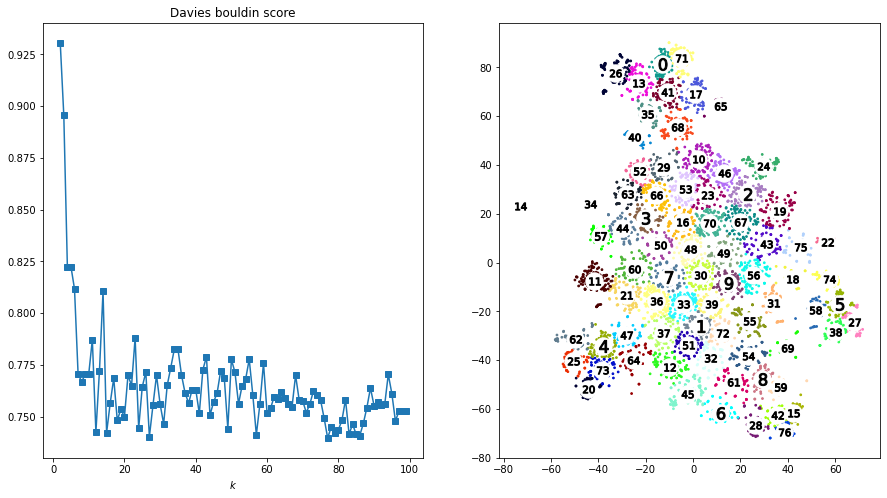

Adjusted Rand Index = 0.020860613583909837
Best k = 77
Wall time: 4min 2s


In [39]:
%%time
dbs = []
max_k = 100

tag_dict = {}
y = []
counter = 0

for tag in news2.Class:
    if not tag_dict.get(tag) and tag_dict.get(tag) != 0:
        tag_dict[tag] = counter
        counter +=1
    y.append(tag_dict[tag])

best_k = (2, 9999)

for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(tsne_vct)
    dbs_score = davies_bouldin_score(tsne_vct, kmeans.labels_)
    dbs.append(dbs_score)
    if dbs_score < best_k[1]:
        best_k = (k, dbs_score)
kmeans = KMeans(n_clusters=best_k[0], random_state=1).fit(tsne_vct)

fig, ax = plt.subplots(1, 2, figsize = (15, 8))

ax[0].plot(range(2, max_k), dbs, marker='s')
ax[0].set_xlabel('$k$')
ax[0].set_title('Davies bouldin score')

myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(kmeans.labels_)+1)) # Генерируем контрастную карту цветов.

ax[1].scatter(tsne_vct[:, 0], tsne_vct[:, 1], s=3, c=kmeans.labels_, cmap=myclr)
ax[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                  marker='o', c="white", alpha=1, s=300)
for i, c in enumerate(kmeans.cluster_centers_):
        ax[1].scatter(c[0], c[1], marker='$%d$' % i, alpha=1, c='black', s = 150)

plt.show()

print('Adjusted Rand Index = ' + str(adjusted_rand_score(kmeans.labels_, y)))
print('Best k = ' + str(best_k[0]))

## Дэндограммы

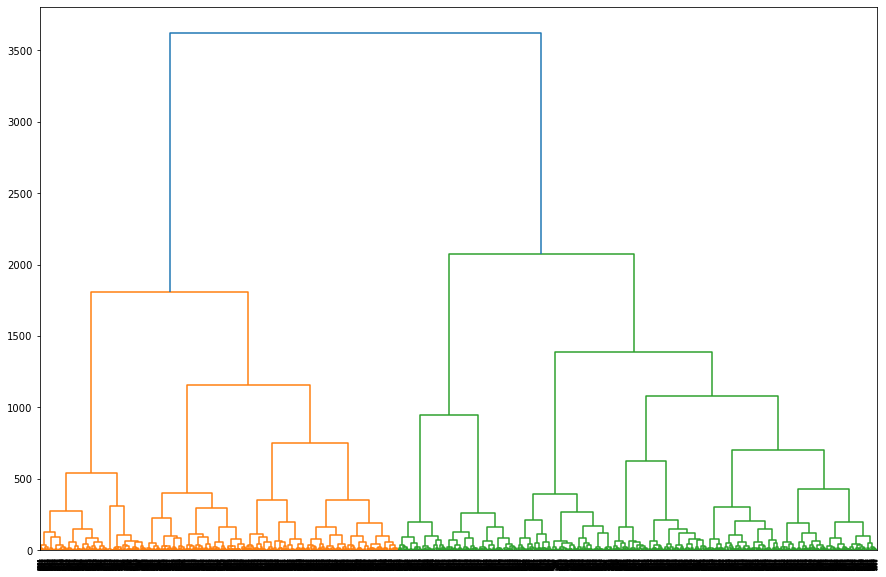

Wall time: 9min 38s


In [44]:
%%time
Y = linkage(tsne_vct, method='ward')
fig, ax = plt.subplots(figsize=(15, 10))
Z = dendrogram(Y)
plt.show()

На уровне около 100 значений, можно насчитать 86 кластеров

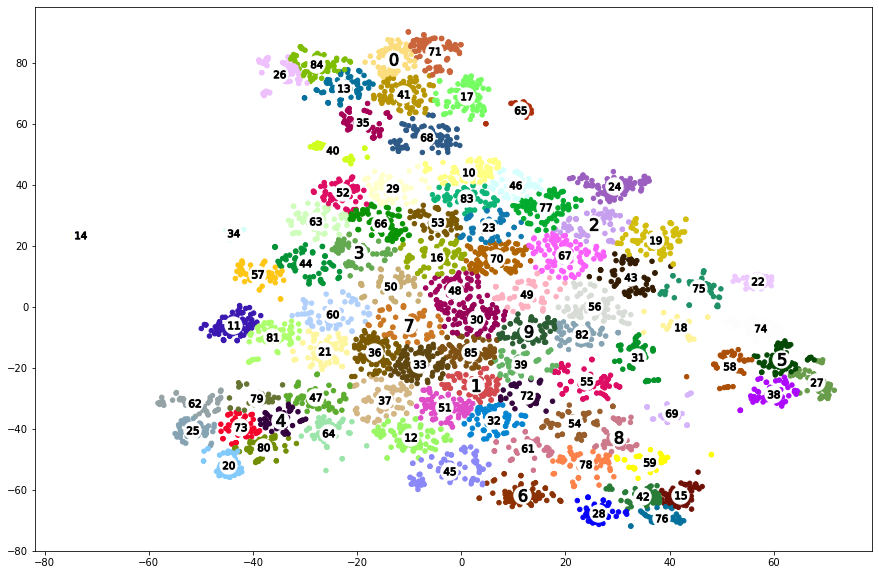

Adjusted Rand Index = 0.018609717529969236


In [40]:
tag_dict = {}
y = []
counter = 0

for tag in news2.Class:
    if not tag_dict.get(tag) and tag_dict.get(tag) != 0:
        tag_dict[tag] = counter
        counter +=1
    y.append(tag_dict[tag])

kmeans = KMeans(n_clusters=86, random_state=1).fit(tsne_vct)

fig, ax = plt.subplots(figsize = (15, 10))

myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(kmeans.labels_)+1)) # Генерируем контрастную карту цветов.

ax.scatter(tsne_vct[:, 0], tsne_vct[:, 1], s=20, c=kmeans.labels_, cmap=myclr)
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                  marker='o', c="white", alpha=1, s=300)
for i, c in enumerate(kmeans.cluster_centers_):
        ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, c='black', s = 150)

plt.show()

print('Adjusted Rand Index = ' + str(adjusted_rand_score(kmeans.labels_, y)))

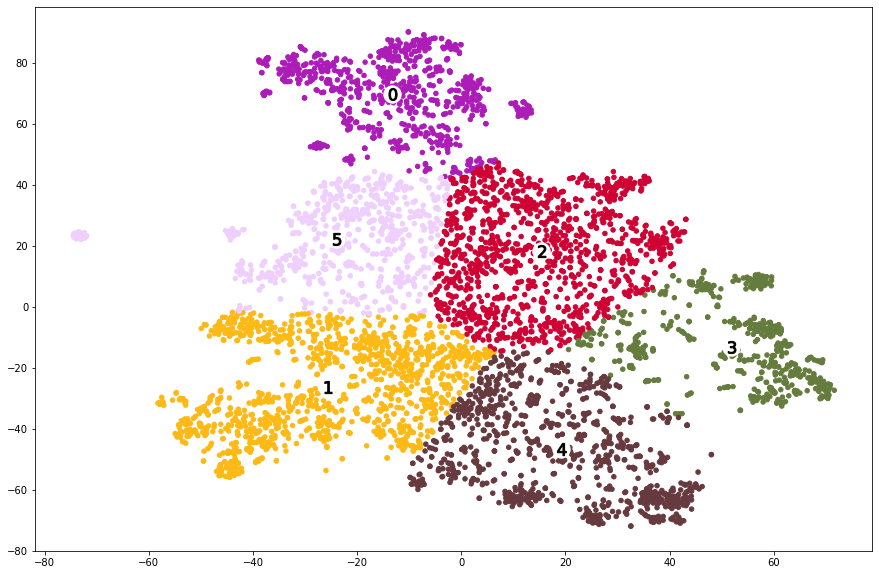

Adjusted Rand Index = 0.1437351354565455


In [37]:
tag_dict = {}
y = []
counter = 0

for tag in news2.Class:
    if not tag_dict.get(tag) and tag_dict.get(tag) != 0:
        tag_dict[tag] = counter
        counter +=1
    y.append(tag_dict[tag])

kmeans = KMeans(n_clusters=6, random_state=1).fit(tsne_vct)

fig, ax = plt.subplots(figsize = (15, 10))

myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(kmeans.labels_)+1)) # Генерируем контрастную карту цветов.

ax.scatter(tsne_vct[:, 0], tsne_vct[:, 1], s=20, c=kmeans.labels_, cmap=myclr)
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                  marker='o', c="white", alpha=1, s=300)
for i, c in enumerate(kmeans.cluster_centers_):
        ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, c='black', s = 150)

plt.show()

print('Adjusted Rand Index = ' + str(adjusted_rand_score(kmeans.labels_, y)))